In [375]:
import numpy as np
import pandas as pd
import random
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


df_wine = pd.read_csv("Wine.csv", header = None)
print('Understand the wine dataset first.')
df_wine

Understand the wine dataset first.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [376]:
from collections import Counter
labels = df_wine.iloc[:, 0].values
label_kinds = np.unique(labels)
print(f'Wine labels: {label_kinds}')
label_cnt = Counter(labels)
for i in range(len(label_kinds)):
    print(f'The numbers of {i + 1}-th label: {label_cnt[label_kinds[i]]} ')

Wine labels: [1 2 3]
The numbers of 1-th label: 59 
The numbers of 2-th label: 71 
The numbers of 3-th label: 48 


In [377]:
X_wine = df_wine.iloc[:, range(0, 14)].values
X_1, X_2, X_3 = X_wine[:59], X_wine[59:59+71], X_wine[59+71:]
np.random.shuffle(X_1)
np.random.shuffle(X_2)
np.random.shuffle(X_3)

X_test = np.concatenate((X_1[:18], X_2[:18], X_3[:18]))
X_train = np.concatenate((X_1[18:], X_2[18:], X_3[18:]))

pd.DataFrame(X_test).to_csv('test.csv', index=False, header=False)
pd.DataFrame(X_train).to_csv('train.csv', index=False, header=False)

# obtain label
y_train = X_train[:, 0].astype(dtype=np.int32)
y_test = X_test[:, 0].astype(dtype=np.int32)

# remove the column of labels
X_train = X_train[:, 1:] 
X_test = X_test[:, 1:]
print(f'Training set: {X_train.shape}, Testing set: {X_test.shape}')

Training set: (124, 13), Testing set: (54, 13)


In [378]:
# calculate the prior
labels = list(Counter(y_train).values())
print(f'Distribution of labels: {labels}')
prior = [val / X_train.shape[0] for val in labels]
print(f'Prior probability: {prior}')
# calculate the likelihood
likelihood = [[], [], []]

for idx in range(X_train.shape[1]):
    # print(X_train[:labels[0], idx].shape)
    # label 1
    mean_1 = np.mean(X_train[:labels[0], idx])
    std_1 = np.std(X_train[:labels[0], idx])
    # label 2
    mean_2 = np.mean(X_train[labels[0]:labels[0]+labels[1], idx])
    std_2 = np.std(X_train[labels[0]:labels[0]+labels[1], idx])
    # label 3
    mean_3 = np.mean(X_train[labels[0]+labels[1]:labels[0]+labels[1]+labels[2], idx])
    std_3 = np.std(X_train[labels[0]+labels[1]:labels[0]+labels[1]+labels[2], idx])
    likelihood[0].append(st.norm(mean_1, std_1).pdf)
    likelihood[1].append(st.norm(mean_2, std_2).pdf)
    likelihood[2].append(st.norm(mean_3, std_3).pdf)

Distribution of labels: [41, 53, 30]
Prior probability: [0.33064516129032256, 0.4274193548387097, 0.24193548387096775]


In [379]:
'''
How I obtain the posterior probability


'''
prediction = []
for ins in X_test:
    posterior_arr = []
    for i in range(3):
        posterior = 1. * prior[i]
        for idx in range(X_train.shape[1]):
            test_val = ins[idx]
            posterior *= likelihood[i][idx](test_val)
        posterior_arr.append(posterior)
    prediction.append(np.argmax(posterior_arr) + 1)

acc_cnt = 0
for i in range(len(prediction)):
    if prediction[i] == y_test[i]:
        acc_cnt += 1
print(f'Accuracy: {acc_cnt / len(prediction) * 100:.1f} %')


Accuracy: 98.1 %


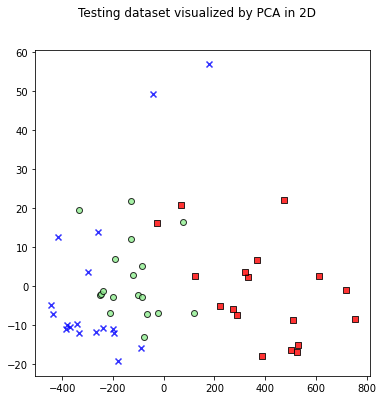

In [380]:
from sklearn.decomposition import PCA

def plot_PCA(X, y, is_3d=False):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    for idx, cl in enumerate(np.unique(y)):
        if is_3d == True:
            ax.scatter(X[y == cl, 0], 
                    X[y == cl, 1],
                    X[y == cl, 2],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black') 
        else:
            plt.scatter(X[y == cl, 0], 
                        X[y == cl, 1],
                        alpha=0.8, 
                        c=colors[idx],
                        marker=markers[idx], 
                        label=cl, 
                        edgecolor='black')

pca_func = PCA(n_components=2)
X_test_pca = pca_func.fit_transform(X_test)
# X_test_pca.shape
fig = plt.figure(figsize=(6,6))
plt.suptitle('Testing dataset visualized by PCA in 2D')
# Plot the scatter graph to understand the PCA in 2D
plot_PCA(X_test_pca, y_test, is_3d=False)
plt.savefig('pca_2d.png', dpi=300)



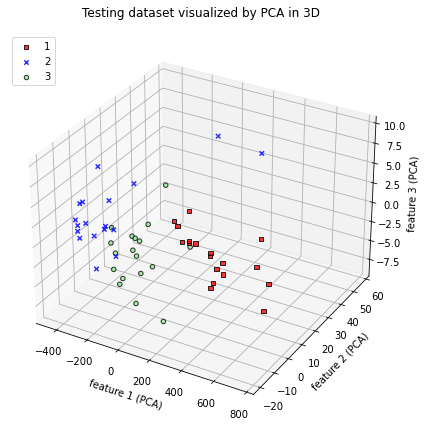

In [381]:
pca3_func = PCA(n_components=3)
X_test_pca3 = pca3_func.fit_transform(X_test)
# X_test_pca3.shape
fig2 = plt.figure(figsize=(6,6))
plt.suptitle('Testing dataset visualized by PCA in 3D')
ax = fig2.add_subplot(projection='3d')

# Plot the scatter graph to understand the PCA in 3D   
plot_PCA(X_test_pca3, y_test, is_3d=True)
ax.set_xlabel('feature 1 (PCA)')
ax.set_ylabel('feature 2 (PCA)')
ax.set_zlabel('feature 3 (PCA)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('pca_3d.png', dpi=300)